In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from tqdm import tqdm

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

# Import packages for data handling
from PIL import Image
from skimage.io import imread


# pytorch
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v2

from albumentations.augmentations.blur import MotionBlur, Defocus
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()
%matplotlib inline

# Set seed nunmber to all packages
seed_number = 42
np.random.seed(seed_number)

E:\2025\pythonProject\.venv\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### **Training Model Anti-Spoofing (Model Klasifikasi dengan CNN dan Transfer Learning MobileNetV2)**

#### **1. Persiapan Dataset dan Preprocessing**
Dataset akan dikumpulkan dan diproses dengan transformasi yang sesuai sebelum dilatih menggunakan MobileNetV2.

##### **Langkah-langkah preprocessing:**
- **Resize gambar** ke ukuran 224x224 piksel.
- **Normalisasi** nilai piksel menggunakan mean dan standar deviasi dari ImageNet.
- **Augmentasi data** opsional untuk meningkatkan ketahanan model.
- **Split dataset** menjadi train, validation, dan test set.

#### **2. Transfer Learning dengan MobileNetV2**
MobileNetV2 adalah model CNN ringan yang telah dilatih sebelumnya di ImageNet. Model ini akan digunakan sebagai feature extractor dengan menyesuaikan fully connected layer terakhir.

##### **Modifikasi pada MobileNetV2:**
- Menggunakan **pretrained MobileNetV2** dari `torchvision.models`.
- Mengganti **output layer** agar sesuai dengan 2 kelas (spoof vs real).
- Menggunakan **CrossEntropyLoss** sebagai loss function.
- Optimizer **Adam** dengan learning rate 0.001.

#### **3. Training Model**
Model akan dilatih menggunakan dataset yang telah diproses dengan langkah-langkah berikut:
- Forward pass melalui model MobileNetV2.
- Menghitung loss menggunakan **CrossEntropyLoss**.
- Backpropagation dan update parameter dengan **Adam optimizer**.
- Validasi model setelah setiap epoch untuk menghindari overfitting.

#### **4. Evaluasi Model dan Implementasi**
Model yang telah dilatih akan dievaluasi menggunakan **confusion matrix** dan metrik evaluasi lainnya seperti akurasi dan F1-score. Model yang telah dioptimalkan akan disimpan dalam format `.pth` dan siap digunakan dalam pipeline program untuk klasifikasi wajah asli dan palsu secara real-time atau batch processing.


In [2]:
input_dir ="Dataset_spoofing"
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

In [3]:
dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

In [4]:
print(f"Main directories\t: {input_dir}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: Dataset_spoofing
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [5]:
import os
import glob
import numpy as np
import pandas as pd

dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
            continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

# Konversi ke DataFrame
case_count_df = pd.DataFrame(case_count)

# Menghitung persentase
percentage_df = case_count_df.div(case_count_df.sum(axis=0), axis=1) * 100

# Gabungkan dengan DataFrame awal
dataset_summary = case_count_df.copy()
dataset_summary["Total"] = case_count_df.sum(axis=1)
dataset_summary["Train (%)"] = percentage_df["train"]
dataset_summary["Val (%)"] = percentage_df["val"]
dataset_summary["Test (%)"] = percentage_df["test"]

print(f"Dataset summary:\n\n{dataset_summary}")


Dataset summary:

       train   val  test  Total  Train (%)    Val (%)  Test (%)
real    1223   405   314   1942  14.736715  13.738128   4.14248
spoof   7076  2543  7266  16885  85.263285  86.261872  95.85752


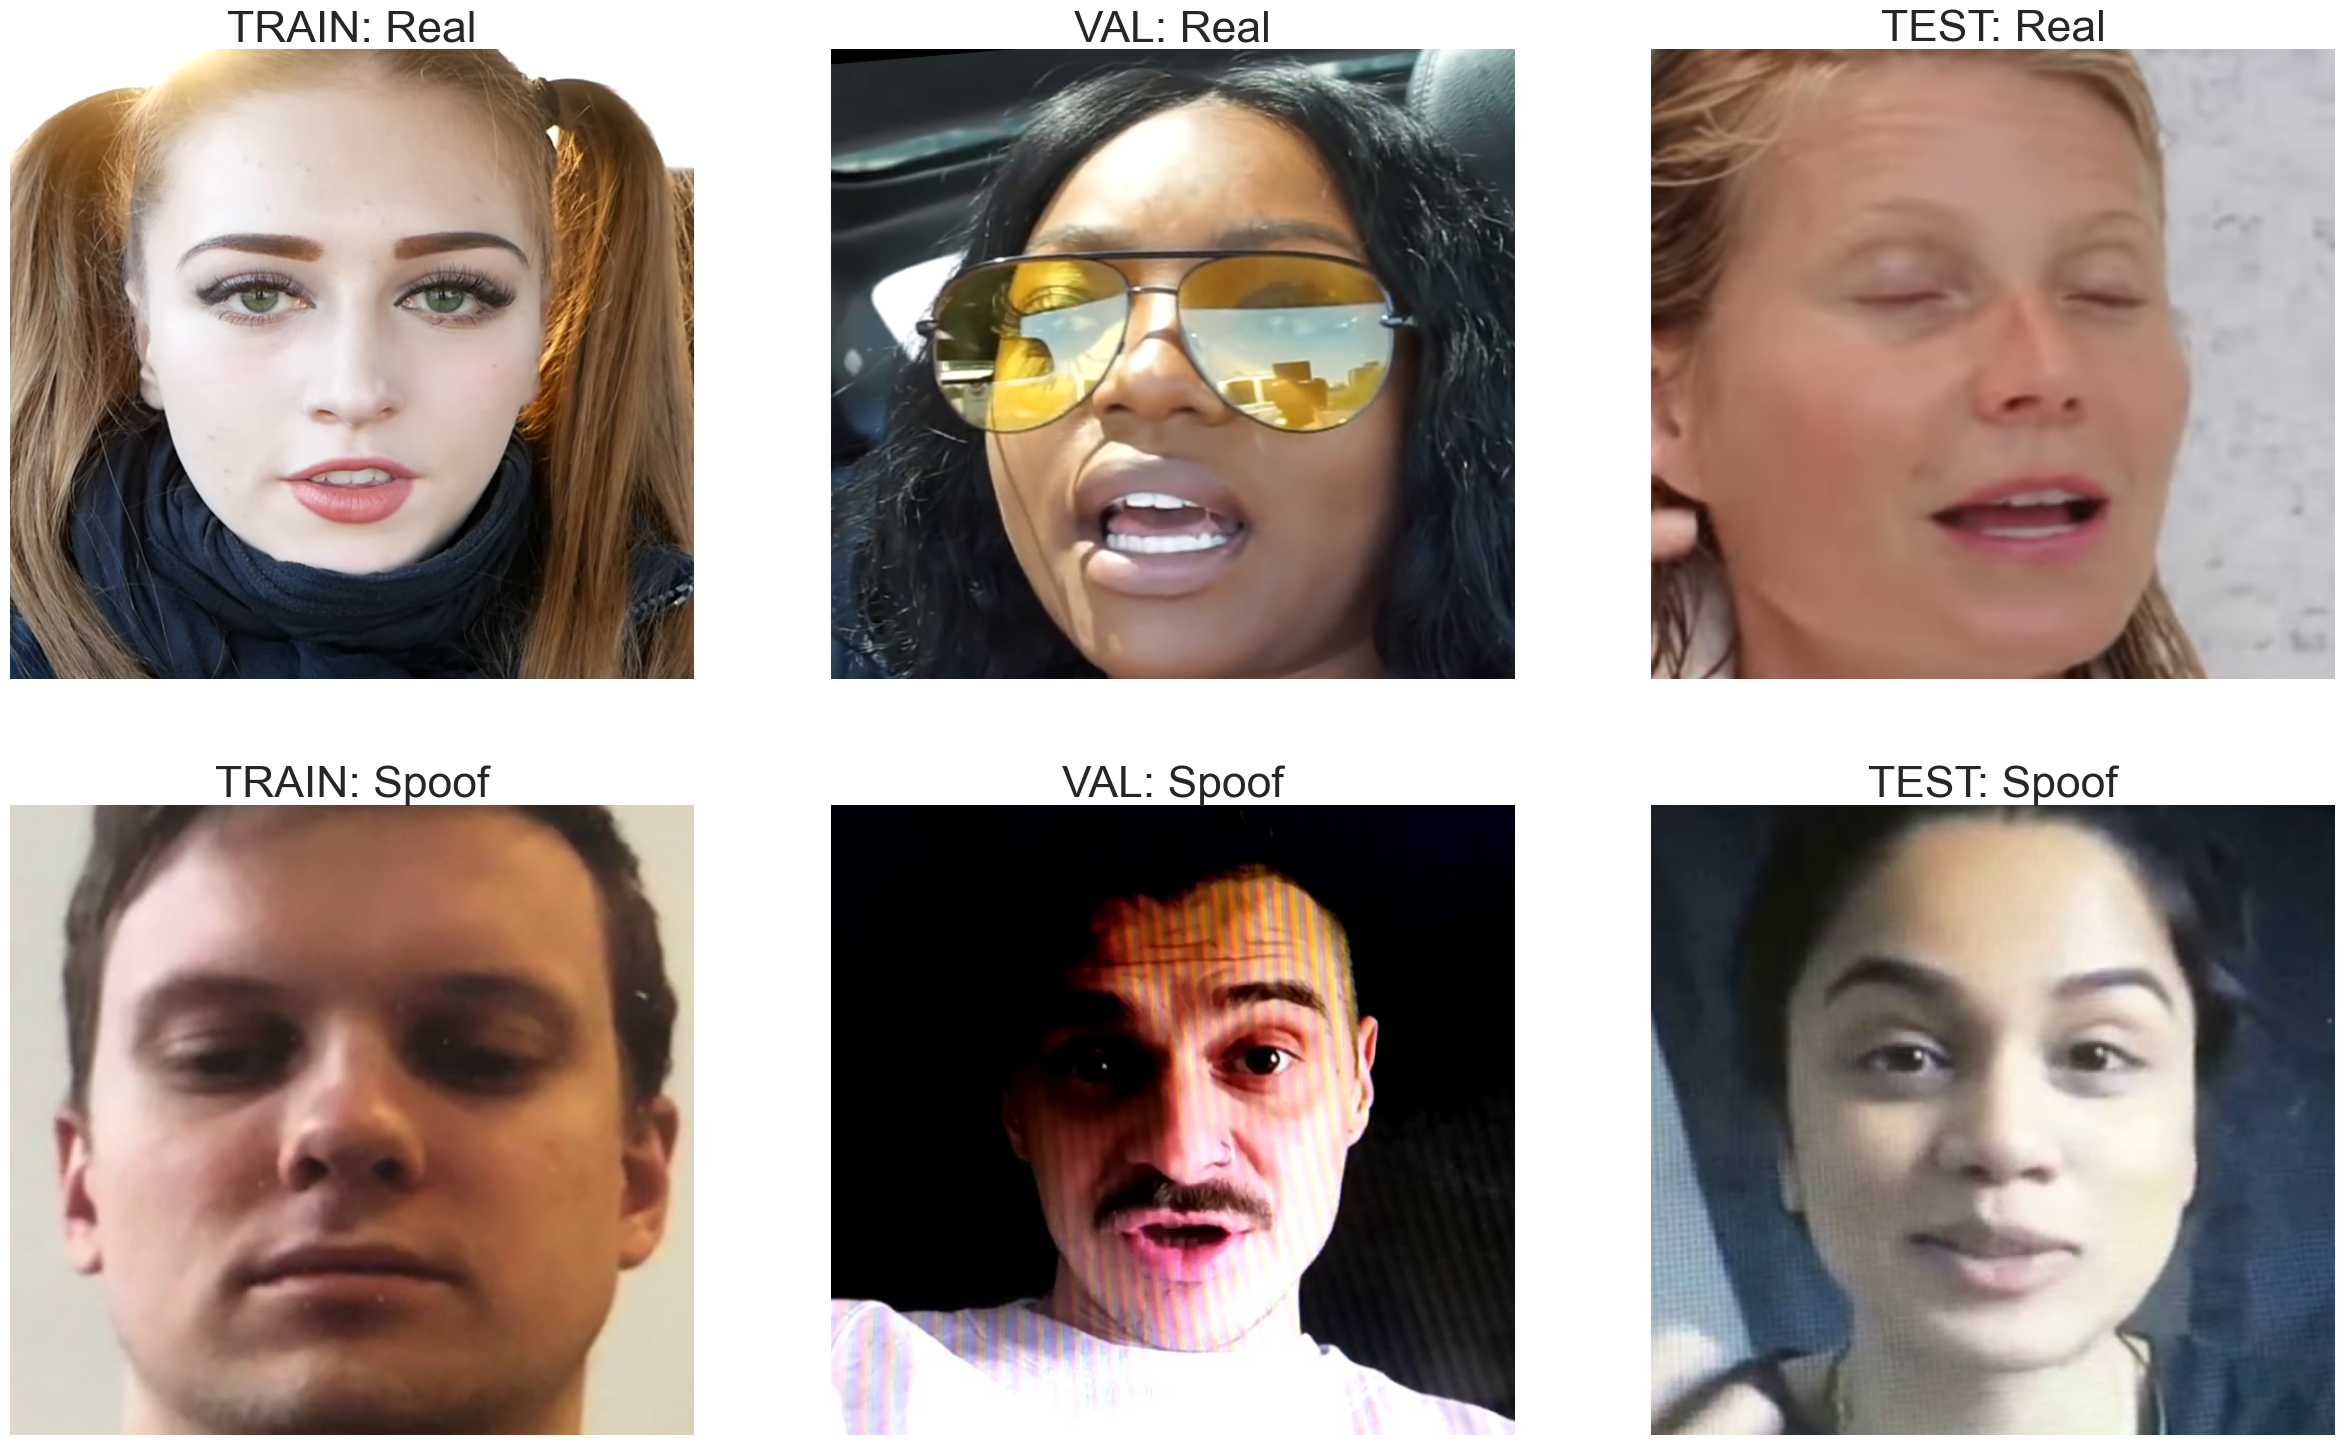

In [6]:
# Visualizing some of the data set
num_classes = len(label_name)
num_dataset = 0
for key, val in set_length.items():
  num_dataset += 1 if val > 0 else 0

f, ax = plt.subplots(num_classes, num_dataset, figsize=(num_dataset*10, 18))

for k in range(num_classes*num_dataset):
    j, i = k//num_dataset, k%num_dataset  # Image indexing
    img_disp_df = pd.DataFrame(img_disp) 
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

### data preprocessing

In [7]:
# Define the data transformations for training, validation, and testing
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomRotation(20),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.15),
# #     transforms.RandomZoom(0.15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [8]:
train_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.augmentations.transforms.ISONoise(
        color_shift=(0.15, 0.35), 
        intensity=(0.1, 0.5), 
        always_apply=False, 
        p=0.05),
    A.augmentations.transforms.RandomBrightnessContrast(
        brightness_limit=(-0.2, 0.2),
        contrast_limit=(-0.2, 0.2),
        always_apply=False,
        brightness_by_max=True, p=0.125),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.augmentations.transforms.ImageCompression(
        quality_lower=50,
        quality_upper=100,
        always_apply=False,
        p=0.25),
    A.augmentations.dropout.CoarseDropout(
        max_holes=24,
        max_height=8,
        max_width=8,
        min_holes=4,
        min_height=4,
        min_width=4,
        fill_value=0,
        always_apply=False,
        p=0.25),
    A.augmentations.transforms.GaussNoise(
        var_limit=(10.0, 50.0),
        mean=0,
        always_apply=False,
        p=0.2),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0, p=1.0),
    A.augmentations.geometric.transforms.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.1, 
        rotate_limit=15, 
        interpolation=cv2.INTER_CUBIC, 
        border_mode=cv2.BORDER_REFLECT_101, 
        always_apply=False, 
        p=0.5),
    A.augmentations.geometric.transforms.Affine(
        scale=(0.5, 1.5), 
        translate_percent=(0.1, 0.2), 
        rotate=(-15, 15), 
        shear=(-8, 8), 
        interpolation=cv2.INTER_CUBIC, 
        always_apply=False, 
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


In [9]:
val_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # To tensor
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # To tensor
    ToTensorV2(),
])

In [10]:
def gen_df(img_dir):
    real_img_dir = os.path.join(img_dir, 'real')
    spoof_img_dir = os.path.join(img_dir, 'spoof')
    real_files = [os.path.join(real_img_dir, f) for f in os.listdir(real_img_dir) if os.path.isfile(os.path.join(real_img_dir, f))]
    spoof_files = [os.path.join(spoof_img_dir, f) for f in os.listdir(spoof_img_dir) if os.path.isfile(os.path.join(spoof_img_dir, f))]

    # Create DataFrame
    data = {
        'file_path': real_files + spoof_files,
        'live': [1] * len(real_files) + [0] * len(spoof_files)
    }
    
    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

Kolom live dalam dictionary data digunakan sebagai label untuk membedakan antara dua jenis gambar dalam dataset:

1. Gambar asli (real/live) → Diberi label 1
2. Gambar palsu (spoof/fake) → Diberi label 0

[1] * len(real_files) menghasilkan list dengan nilai 1 sebanyak jumlah file asli.
[0] * len(spoof_files) menghasilkan list dengan nilai 0 sebanyak jumlah file palsu.

In [11]:
df_train = gen_df(dir_dict['train'])
df_val = gen_df(dir_dict['val'])
df_test = gen_df(dir_dict['test'])

In [12]:
df_train['live'].value_counts()

live
0    7076
1    1223
Name: count, dtype: int64

In [13]:
df_train['file_path'][2]

'Dataset_spoofing\\LCC_FASD_training\\spoof\\YOUTUBE_HP620_IPHONE4_id57_s1_90.png'

In [14]:
df_train['live'][0]

0

In [15]:
df_train_0 = df_train[df_train['live']==0][:1223]
df_train_1 = df_train[df_train['live']==1][:1223]
df_train_balanced = pd.concat([df_train_0, df_train_1]).reset_index(drop=True)
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_train_balanced

file_path  live
0     Dataset_spoofing\LCC_FASD_training\real\IPHONE...     1
1     Dataset_spoofing\LCC_FASD_training\real\YOUTUB...     1
2     Dataset_spoofing\LCC_FASD_training\spoof\YOUTU...     0
3     Dataset_spoofing\LCC_FASD_training\real\YOUTUB...     1
4     Dataset_spoofing\LCC_FASD_training\spoof\YOUTU...     0
...                                                 ...   ...
2441  Dataset_spoofing\LCC_FASD_training\real\YOUTUB...     1
2442  Dataset_spoofing\LCC_FASD_training\spoof\YOUTU...     0
2443  Dataset_spoofing\LCC_FASD_training\spoof\FT720...     0
2444  Dataset_spoofing\LCC_FASD_training\real\YOUTUB...     1
2445  Dataset_spoofing\LCC_FASD_training\spoof\YOUTU...     0

[2446 rows x 2 columns]

In [16]:
df_train_balanced['live'].value_counts()

live
1    1223
0    1223
Name: count, dtype: int64

In [17]:
df_val['live'].value_counts()

live
0    2543
1     405
Name: count, dtype: int64

In [18]:
df_val_0 = df_val[df_val['live']==0][:405]
df_val_1 = df_val[df_val['live']==1][:405]
df_val_balanced = pd.concat([df_val_0, df_val_1]).reset_index(drop=True)
df_val_balanced = df_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_val_balanced['live'].value_counts()

live
0    405
1    405
Name: count, dtype: int64

In [19]:
df_test['live'].value_counts()

live
0    7266
1     314
Name: count, dtype: int64

In [20]:
df_test_0 = df_test[df_test['live']==0][:314]
df_test_1 = df_test[df_test['live']==1][:314]
df_test_balanced = pd.concat([df_test_0, df_test_1]).reset_index(drop=True)
df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_balanced['live'].value_counts()

live
1    314
0    314
Name: count, dtype: int64

In [21]:
class FASDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['live']
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        image = Image.open(img_path)
        image = np.array(image)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        return image, label

In [22]:
train_dataset = FASDataset(df_train, train_transform)
val_dataset = FASDataset(df_val, val_transform)
test_dataset = FASDataset(df_test, test_transform)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
img, label = next(iter(dataloader_train))
img.size(), label.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using \'{}\' device'.format(device))

using 'cuda' device


In [125]:
import torchvision
import torchvision.models as models
class SpoofNet(nn.Module):
    def __init__(self):
        super(SpoofNet, self).__init__()
        # Load pretrained MobileNetV2
        self.pretrained_net = mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.features = self.pretrained_net.features
        
        # Adaptive pooling and fully connected layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (1,1,1280)
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(0.3),  # More dropout for regularization
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.global_avg_pool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 1280)
        x = self.fc(x)  # Fully connected layer
        return x  # No sigmoid, use BCEWithLogitsLoss()

# Instantiate the model and print the summary
model = SpoofNet()
model.to(device)

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [26]:
num_epochs = 40
learning_rate = 5e-5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(
    optimizer, factor=0.2, patience=3, verbose=True, 
    threshold=0.005, min_lr=5e-7,
)

# dict to store history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'learning_rate': [],
}

best_val_loss = 0.0
save_dir = 'mobilenet_training_attempt2'

# define checkpoint paths
cont_filepath = os.path.join(save_dir, "mobilenetv2-epoch_{}.pt")
best_filepath = os.path.join(save_dir, "mobilenetv2-best.pt")

def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filepath)

In [28]:
for epoch in range(num_epochs):
    print('epoch: {}/{}'.format(epoch+1, num_epochs))
    print('-----------------------')
    model.train()
    running_loss = 0.0
    train_total = 0
    train_correct = 0
    prog_bar_train = tqdm(dataloader_train, desc='training')
    for inputs, labels in prog_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # update progress
        prog_bar_train.set_postfix({'acc': round(train_correct / train_total, 2)})
        
    train_acc = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(dataloader_train)

    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(train_acc)
    
    # validate the model --------------------------------------------------
    model.eval()
    running_val_loss = 0.0
    val_total = 0
    val_correct = 0
    prog_bar_val = tqdm(dataloader_val, desc='validating')
    with torch.no_grad():
        for inputs, labels in prog_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # update progress
            prog_bar_val.set_postfix({'acc': round(val_correct / val_total, 4)})
    
     
    avg_val_loss = running_val_loss / len(dataloader_val)
    scheduler.step(avg_val_loss)
    
    val_acc = 100 * val_correct / val_total

    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    
    
    # Check for improvement ---------------------------
    if epoch == 0:
        best_val_loss = avg_val_loss
        is_best = True
    else:
        is_best = avg_val_loss < best_val_loss
        best_val_loss = min(avg_val_loss, best_val_loss)
    
    checkpoint_filepath = cont_filepath.format(epoch+1)
    print('saving checkpoint: {}'.format(checkpoint_filepath))
    save_checkpoint(
        {'epoch': epoch + 1,
         'state_dict': model.state_dict(),
         'optimizer': optimizer.state_dict(),},
        is_best,
        checkpoint_filepath
    )

    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rate'].append(current_lr)
    
    
    # print loss and accuracy
    print(f'Epoch: {epoch+1}/{num_epochs}'),
    print('Loss/train: {}'.format(avg_train_loss))
    print('Loss/val: {}'.format(avg_val_loss))
    print('Acc/train: {}%'.format(train_acc))
    print('Acc/val: {}%'.format(val_acc))
    print('current lr: {}'.format(current_lr))


epoch: 1/40
-----------------------


validating: 100%|██████████| 93/93 [00:53<00:00,  1.72it/s, acc=0.891]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_1.pt
Epoch: 1/40
Loss/train: 0.19193664750514122
Loss/val: 0.3123949016294172
Acc/train: 90.62537655139174%
Acc/val: 89.14518317503392%
current lr: 5e-05
epoch: 2/40
-----------------------


validating: 100%|██████████| 93/93 [00:40<00:00,  2.31it/s, acc=0.95] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_2.pt
Epoch: 2/40
Loss/train: 0.14623741610692098
Loss/val: 0.16317208852338536
Acc/train: 94.18002168936016%
Acc/val: 95.0135685210312%
current lr: 5e-05
epoch: 3/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.46it/s, acc=0.913]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_3.pt
Epoch: 3/40
Loss/train: 0.13586061634839727
Loss/val: 0.2714209402761152
Acc/train: 94.57765995903121%
Acc/val: 91.31614654002713%
current lr: 5e-05
epoch: 4/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.952]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_4.pt
Epoch: 4/40
Loss/train: 0.10791124543891503
Loss/val: 0.16962823069464134
Acc/train: 95.68622725629594%
Acc/val: 95.14925373134328%
current lr: 5e-05
epoch: 5/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.957]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_5.pt
Epoch: 5/40
Loss/train: 0.1167732941201673
Loss/val: 0.1548155109768593
Acc/train: 95.39703578744427%
Acc/val: 95.69199457259158%
current lr: 5e-05
epoch: 6/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.50it/s, acc=0.952]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_6.pt
Epoch: 6/40
Loss/train: 0.1101024133583101
Loss/val: 0.16586387302646394
Acc/train: 95.66212796722496%
Acc/val: 95.1831750339213%
current lr: 5e-05
epoch: 7/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.959]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_7.pt
Epoch: 7/40
Loss/train: 0.10240274632815272
Loss/val: 0.13317027614922614
Acc/train: 95.87902156886372%
Acc/val: 95.92944369063773%
current lr: 5e-05
epoch: 8/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.883]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_8.pt
Epoch: 8/40
Loss/train: 0.09499874977538218
Loss/val: 0.38735798810438443
Acc/train: 96.04771659236053%
Acc/val: 88.29715061058344%
current lr: 5e-05
epoch: 9/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.955]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_9.pt
Epoch: 9/40
Loss/train: 0.08287486446654209
Loss/val: 0.1538556777141107
Acc/train: 96.56585130738644%
Acc/val: 95.5223880597015%
current lr: 5e-05
epoch: 10/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.97] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_10.pt
Epoch: 10/40
Loss/train: 0.09261771413999108
Loss/val: 0.11878092775136352
Acc/train: 96.18026268225087%
Acc/val: 96.94708276797829%
current lr: 5e-05
epoch: 11/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.51it/s, acc=0.98] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_11.pt
Epoch: 11/40
Loss/train: 0.0862524282760345
Loss/val: 0.07727460588719096
Acc/train: 96.2525605494638%
Acc/val: 98.0325644504749%
current lr: 5e-05
epoch: 12/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.967]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_12.pt
Epoch: 12/40
Loss/train: 0.08589718970470131
Loss/val: 0.11777929564492316
Acc/train: 96.37305699481865%
Acc/val: 96.74355495251018%
current lr: 5e-05
epoch: 13/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.974]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_13.pt
Epoch: 13/40
Loss/train: 0.08332685902714729
Loss/val: 0.10361804259610513
Acc/train: 96.48150379563803%
Acc/val: 97.38805970149254%
current lr: 5e-05
epoch: 14/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.50it/s, acc=0.97] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_14.pt
Epoch: 14/40
Loss/train: 0.08226345574411635
Loss/val: 0.11905876927638567
Acc/train: 96.44535486203156%
Acc/val: 97.01492537313433%
current lr: 5e-05
epoch: 15/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.971]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_15.pt
Epoch: 15/40
Loss/train: 0.07956166790905767
Loss/val: 0.1264504945163505
Acc/train: 96.6742981082058%
Acc/val: 97.11668928086839%
current lr: 1e-05
epoch: 16/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.50it/s, acc=0.959]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_16.pt
Epoch: 16/40
Loss/train: 0.07611926407374155
Loss/val: 0.1538133022227695
Acc/train: 96.81889384263164%
Acc/val: 95.86160108548168%
current lr: 1e-05
epoch: 17/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.97] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_17.pt
Epoch: 17/40
Loss/train: 0.07197106362213022
Loss/val: 0.1268624329278546
Acc/train: 96.87914206530907%
Acc/val: 97.01492537313433%
current lr: 1e-05
epoch: 18/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.971]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_18.pt
Epoch: 18/40
Loss/train: 0.06807551381643862
Loss/val: 0.12279510417933105
Acc/train: 97.10808531148331%
Acc/val: 97.08276797829036%
current lr: 1e-05
epoch: 19/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.51it/s, acc=0.974]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_19.pt
Epoch: 19/40
Loss/train: 0.07101657622350523
Loss/val: 0.11860540102145845
Acc/train: 97.07193637787685%
Acc/val: 97.38805970149254%
current lr: 2.0000000000000003e-06
epoch: 20/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.959]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_20.pt
Epoch: 20/40
Loss/train: 0.06782883056976761
Loss/val: 0.15666836556748195
Acc/train: 97.2888299795156%
Acc/val: 95.86160108548168%
current lr: 2.0000000000000003e-06
epoch: 21/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.955]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_21.pt
Epoch: 21/40
Loss/train: 0.07001568289706483
Loss/val: 0.1718101182937502
Acc/train: 97.21653211230269%
Acc/val: 95.45454545454545%
current lr: 2.0000000000000003e-06
epoch: 22/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.968]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_22.pt
Epoch: 22/40
Loss/train: 0.06490983091688786
Loss/val: 0.13386610631019838
Acc/train: 97.30087962405109%
Acc/val: 96.77747625508819%
current lr: 2.0000000000000003e-06
epoch: 23/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.50it/s, acc=0.972]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_23.pt
Epoch: 23/40
Loss/train: 0.06608802298119722
Loss/val: 0.13419142924249172
Acc/train: 97.31292926858657%
Acc/val: 97.18453188602442%
current lr: 5e-07
epoch: 24/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.972]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_24.pt
Epoch: 24/40
Loss/train: 0.06981434627400282
Loss/val: 0.12574597010489114
Acc/train: 96.87914206530907%
Acc/val: 97.15061058344641%
current lr: 5e-07
epoch: 25/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.966]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_25.pt
Epoch: 25/40
Loss/train: 0.06323213585688231
Loss/val: 0.1501383554360639
Acc/train: 97.49367393661888%
Acc/val: 96.64179104477611%
current lr: 5e-07
epoch: 26/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.967]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_26.pt
Epoch: 26/40
Loss/train: 0.06722581919837886
Loss/val: 0.1345950464808172
Acc/train: 97.18038317869623%
Acc/val: 96.70963364993216%
current lr: 5e-07
epoch: 27/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.973]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_27.pt
Epoch: 27/40
Loss/train: 0.06627089804611527
Loss/val: 0.12376261712928173
Acc/train: 97.36112784672852%
Acc/val: 97.3202170963365%
current lr: 5e-07
epoch: 28/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.973]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_28.pt
Epoch: 28/40
Loss/train: 0.06369445552744975
Loss/val: 0.11830610681765823
Acc/train: 97.4575250030124%
Acc/val: 97.28629579375848%
current lr: 5e-07
epoch: 29/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.54it/s, acc=0.972]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_29.pt
Epoch: 29/40
Loss/train: 0.07207495652927229
Loss/val: 0.12373352009472588
Acc/train: 96.86709242077359%
Acc/val: 97.18453188602442%
current lr: 5e-07
epoch: 30/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.972]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_30.pt
Epoch: 30/40
Loss/train: 0.06819266478101221
Loss/val: 0.11987452524068255
Acc/train: 97.15628388962526%
Acc/val: 97.21845318860244%
current lr: 5e-07
epoch: 31/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.97] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_31.pt
Epoch: 31/40
Loss/train: 0.06565548618986773
Loss/val: 0.13237195114111616
Acc/train: 97.43342571394143%
Acc/val: 96.98100407055631%
current lr: 5e-07
epoch: 32/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.966]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_32.pt
Epoch: 32/40
Loss/train: 0.06935746374611672
Loss/val: 0.14290337410995796
Acc/train: 97.19243282323171%
Acc/val: 96.64179104477611%
current lr: 5e-07
epoch: 33/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.50it/s, acc=0.964]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_33.pt
Epoch: 33/40
Loss/train: 0.07108489328664011
Loss/val: 0.14905682772207723
Acc/train: 97.05988673334137%
Acc/val: 96.37042062415196%
current lr: 5e-07
epoch: 34/40
-----------------------


validating: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s, acc=0.973]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_34.pt
Epoch: 34/40
Loss/train: 0.06947565110077938
Loss/val: 0.1233238182656507
Acc/train: 97.09603566694783%
Acc/val: 97.28629579375848%
current lr: 5e-07
epoch: 35/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.97] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_35.pt
Epoch: 35/40
Loss/train: 0.0628462944054403
Loss/val: 0.12526589838953148
Acc/train: 97.3852271357995%
Acc/val: 96.98100407055631%
current lr: 5e-07
epoch: 36/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.974]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_36.pt
Epoch: 36/40
Loss/train: 0.06572225125094588
Loss/val: 0.11620204787080486
Acc/train: 97.51777322568984%
Acc/val: 97.35413839891451%
current lr: 5e-07
epoch: 37/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.967]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_37.pt
Epoch: 37/40
Loss/train: 0.06188051321794494
Loss/val: 0.13915008873934107
Acc/train: 97.32497891312207%
Acc/val: 96.74355495251018%
current lr: 5e-07
epoch: 38/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.965]


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_38.pt
Epoch: 38/40
Loss/train: 0.06358147040099049
Loss/val: 0.16109631671720454
Acc/train: 97.27678033498012%
Acc/val: 96.47218453188603%
current lr: 5e-07
epoch: 39/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s, acc=0.96] 


saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_39.pt
Epoch: 39/40
Loss/train: 0.06286385689611332
Loss/val: 0.15730904309349436
Acc/train: 97.5539221592963%
Acc/val: 96.03120759837178%
current lr: 5e-07
epoch: 40/40
-----------------------


validating: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s, acc=0.97] 

saving checkpoint: mobilenet_training_attempt2\mobilenetv2-epoch_40.pt
Epoch: 40/40
Loss/train: 0.06994513758601477
Loss/val: 0.12996460592033252
Acc/train: 97.08398602241233%
Acc/val: 96.94708276797829%
current lr: 5e-07


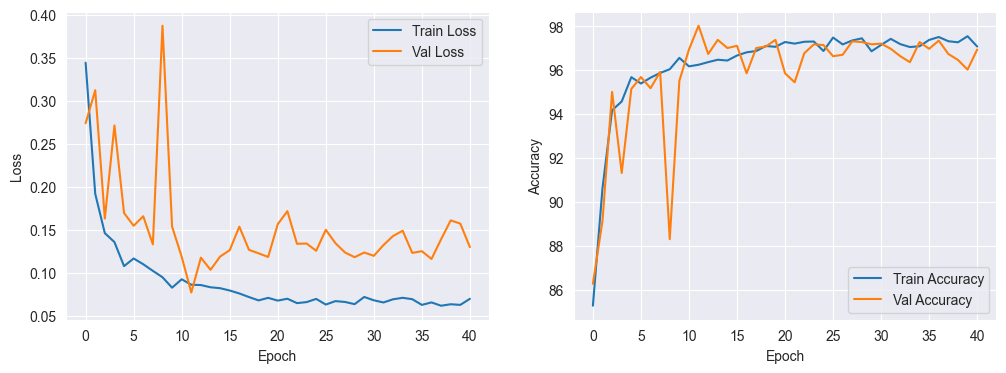

In [29]:
try:
    # Plot the training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
except:
    print("exception while plotting results")

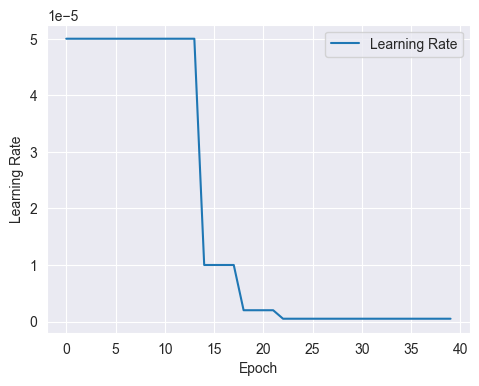

In [30]:
try:   
    plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history['train_f1'], label='Train F1')
#     plt.plot(history['val_f1'], label='Val F1')
#     plt.xlabel('Epoch')
#     plt.ylabel('F1')
#     plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['learning_rate'], label='Learning Rate')
#     plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.show()
except:
    print("exception while plotting results")

In [68]:
pretrained_weight = 'mobilenet_training_attempt2/mobilenetv2-best.pt'


In [70]:
import torch

check_point = torch.load(pretrained_weight)

model_dict = check_point['state_dict']
epoch_ = check_point['epoch']

# # Load the updated state dictionary into the model
model.load_state_dict(model_dict)

model.to(device)
model.eval()
criterion = nn.BCEWithLogitsLoss()

In [71]:
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
prog_bar_test = tqdm(dataloader_test, desc='Testing')

with torch.no_grad():
    for inputs, labels in prog_bar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()
        
        predicted = (outputs > 0.5).int()
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        prog_bar_test.set_postfix({
            'accuracy': correct_predictions / total_predictions * 100,
        })
        
# Calculate average loss and accuracy
test_loss /= len(dataloader_test)
accuracy = correct_predictions / total_predictions * 100

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Testing: 100%|██████████| 237/237 [01:29<00:00,  2.66it/s, accuracy=98.3]

Test Loss: 0.0655
Test Accuracy: 98.31%


## 1. Konversi Model ke TorchScript atau ONNX
Raspberry Pi tidak memiliki GPU yang kuat seperti laptop dengan RTX 4090, jadi inference harus dioptimalkan. Gunakan TorchScript atau ONNX agar lebih ringan.

In [33]:
import torch

# Load model
checkpoint_path = "mobilenet/mobilenetv2-best.pt"
model = SpoofNet()
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Convert ke TorchScript
scripted_model = torch.jit.script(model)
scripted_model.save("mobilenet/mobilenetv2-scripted.pt")

print("✅ Model berhasil dikonversi ke TorchScript!")

✅ Model berhasil dikonversi ke TorchScript!


### evaluasi (confusion matrix)
saya menggunakan metrik sederhana dalam menentukan performa model dengan library seaborn dan numpy


Keterangan:

TP (True Positive) = Wajah asli terdeteksi sebagai "Real" ✅
TN (True Negative) = Wajah palsu terdeteksi sebagai "Spoof" ✅
FP (False Positive) = Wajah palsu terdeteksi sebagai "Real" ❌
FN (False Negative) = Wajah asli terdeteksi sebagai "Spoof" ❌

In [34]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [72]:
checkpoint_path = "mobilenet_training_attempt2/mobilenetv2-best.pt"
model = SpoofNet()
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [73]:
all_labels = []
all_preds = []

Evaluasi model pada data validasi

In [74]:
with torch.no_grad():
    for inputs, labels in tqdm(dataloader_val, desc="Evaluating"):
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

        # 🔹 Prediksi model
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()

        # 🔹 Simpan hasil untuk confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

Evaluating: 100%|██████████| 93/93 [01:14<00:00,  1.26it/s]


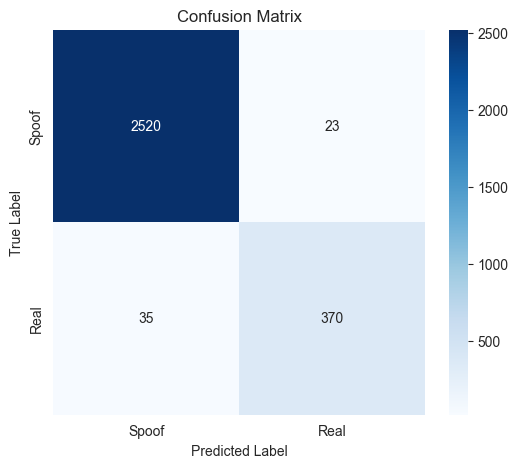

In [75]:
cm = confusion_matrix(all_labels, all_preds)
labels = ["Spoof", "Real"]

# 🔹 Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

📊 Ringkasan Hasil Model
True Negative (TN) = 2,520 → Wajah palsu (spoof) diklasifikasikan dengan benar sebagai spoof ✅
False Positive (FP) = 23 → Wajah palsu (spoof) diklasifikasikan salah sebagai real ❌
False Negative (FN) = 35 → Wajah asli (real) diklasifikasikan salah sebagai spoof ❌
True Positive (TP) = 370 → Wajah asli (real) diklasifikasikan dengan benar sebagai real ✅

In [76]:


# Nilai dari Confusion Matrix
TN = 2520  # True Negative (Spoof terdeteksi dengan benar)
FP = 23   # False Positive (Spoof diklasifikasikan salah sebagai Real)
FN = 35   # False Negative (Real diklasifikasikan salah sebagai Spoof)
TP = 370   # True Positive (Real terdeteksi dengan benar)

# Hitung metrik
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print hasil
print(f'Akurasi: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Akurasi: 0.9803
Precision: 0.9415
Recall: 0.9136
F1-Score: 0.9273


In [152]:
import cv2
import os

def detect_and_crop_faces_from_folder():
    # Buat direktori 'save_picture' jika belum ada
    save_dir = 'test_langsung_crop'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Muat classifier Haar Cascade untuk deteksi wajah
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Folder sumber gambar
    image_folder = 'test_langsung'
    save_folder = 'test_langsung_crop'
    
    # Ambil semua file gambar dalam folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Gagal membaca gambar {image_file}.")
            continue

        # Konversi frame ke grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Deteksi wajah
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Jika ada wajah yang terdeteksi
        for i, (x, y, w, h) in enumerate(faces):
            # Lakukan cropping pada bounding box
            cropped_face = frame[y:y + h, x:x + w]
            
            # Simpan gambar hasil cropping
            save_path = os.path.join(save_folder, f'cropped_{os.path.splitext(image_file)[0]}_{i}.jpg')
            cv2.imwrite(save_path, cropped_face)
            print(f"Gambar disimpan di {save_path}")

if __name__ == "__main__":
    detect_and_crop_faces_from_folder()


Gambar disimpan di test_langsung_crop\cropped_cropped_face_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0006_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0007_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0008_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0009_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0011_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0012_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0013_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0014_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0015_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0016_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0017_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0018_0.jpg
Gambar disimpan di test_langsung_crop\cropped_IMG-20250314-WA0019_0.jpg

In [84]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
# 🔹 Load model TorchScript
model = SpoofNet().to(device)
checkpoint_path = "mobilenet_training_attempt2/mobilenetv2-best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 🔹 Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


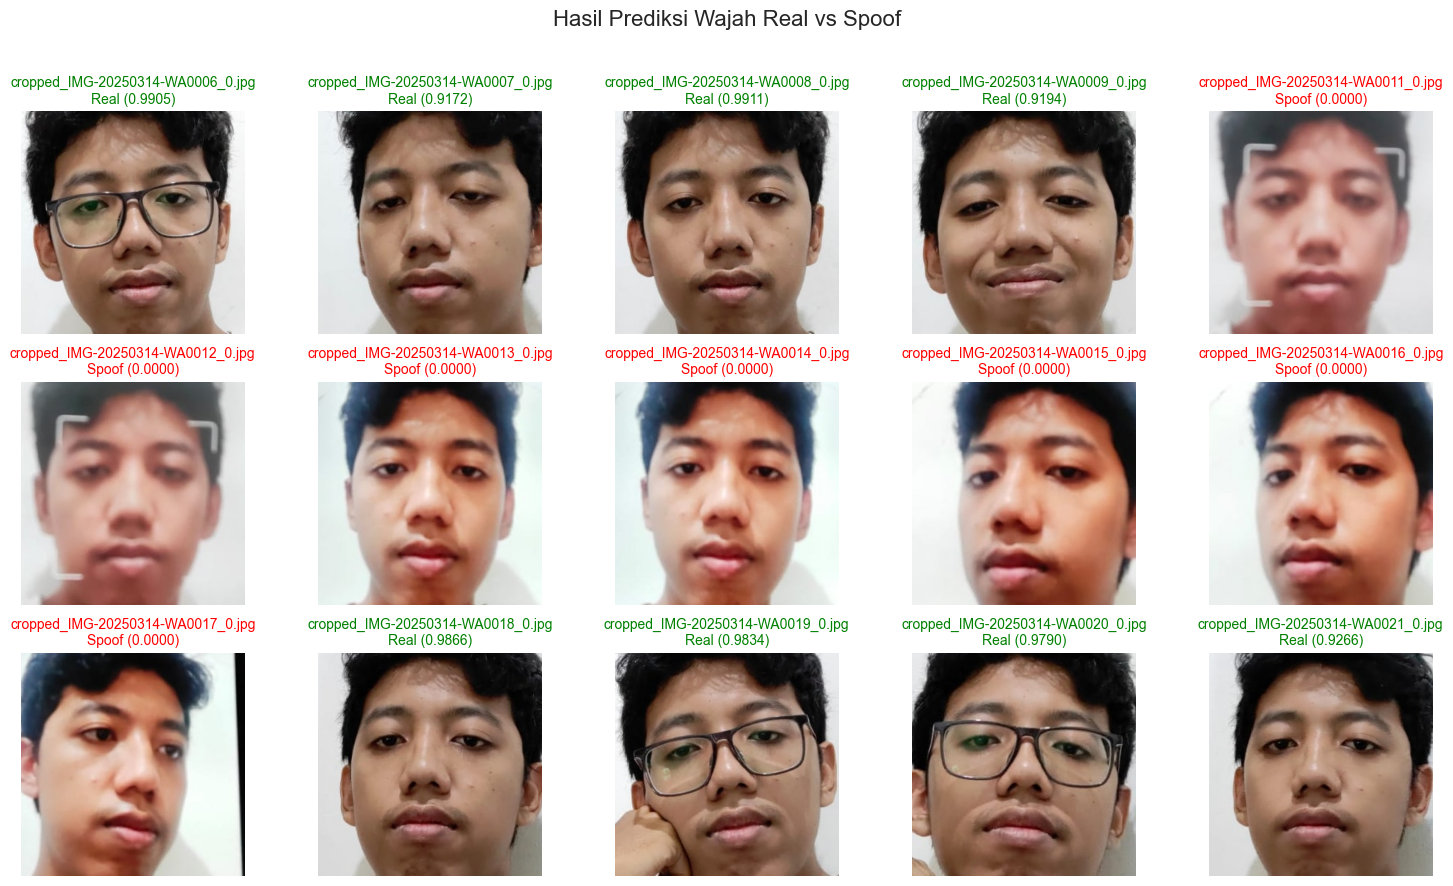

In [151]:

# 🔹 Load gambar dari folder
image_folder = "test_langsung_crop"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle("Hasil Prediksi Wajah Real vs Spoof", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(image_files):
        ax.axis("off")
        continue
    
    image_path = os.path.join(image_folder, image_files[i])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output).item()
    
    label = "Real" if prob > 0.5 else "Spoof"
    color = "green" if label == "Real" else "red"
    
    ax.imshow(image)
    ax.set_title(f"{image_files[i]}\n{label} ({prob:.4f})", color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### konversi ke torchscripted
#### model butuh dilakukan quantize
quantize merupakan proses untuk mengubah tipe data yang dilakukan pada saat load model, tidak ketika input dan output melainkan proses untuk memudahkan load data, model data yang digunakan pada laptop dengan prosesor x86 perlu diubah ke spek yang sesuai dengan arm dengan mengubah tipe data float32 menjadi uint8

#### model juga butuh dilakukan pruning
model memiliki beberapa layer yang memiliki weight yang berat, terutama saya menggunakan kerangka dari mobilenet yang cukup berat digunakan pada raspberry pi, untuk itu saya perlu mengurangi weight tiap layer yang cukup banyak

#### load model

In [87]:
checkpoint_path = "mobilenet_training_attempt2/mobilenetv2-best.pt"
model = SpoofNet()
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

#### lanjut ke pruning

In [91]:
import torch.nn.utils.prune as prune
for name, module in model.features.named_modules():
    if isinstance(module, nn.Conv2d):
        # Prune 30% dari filter (structured pruning per filter)
        prune.ln_structured(module, name="weight", amount=0.3, n=2, dim=0)  # Prune per filter

# 4. Terapkan pruning juga ke layer Linear
for name, module in model.fc.named_modules():
    if isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.3)

# 5. (Opsional) Hapus reparameterisasi agar pruning permanen
def remove_pruning(model):
    for module in model.modules():
        if hasattr(module, "weight_orig"):
            prune.remove(module, "weight")

remove_pruning(model)

torch.save({'state_dict' : model.state_dict()}, "spoofnet_prunedv2.pt")
print("Model pruned dan disimpan ke 'spoofnet_prunedv2.pt'")

Model pruned dan disimpan ke 'spoofnet_prunedv2.pt'


In [92]:
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===========
# Model Class
# ===========
class SpoofNet(nn.Module):
    def __init__(self):
        super(SpoofNet, self).__init__()
        self.pretrained_net = mobilenet_v2(weights=None)
        self.features = self.pretrained_net.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ======================
# Load Checkpoint Model
# ======================
model = SpoofNet().to(device)
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=device)
model.load_state_dict(checkpoint['state_dict'])

# ======================
# Optimizer, Loss, Scheduler
# ======================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



### lanjut ke quantize model
#### quantize dilakukan dengan konversi tipe data saat proses load model dari float32 ke uint8

In [100]:
import torch
import torch.quantization
import torch.nn as nn

# ======================
# Load Model Pruned
# ======================
model = SpoofNet().to(device)  # Pastikan model sudah di-inisialisasi dengan benar
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=device)
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [101]:

# ============================
# 1. Persiapkan Model untuk Quantization
# ============================
model.eval()  # Pastikan model dalam mode evaluasi

# Tentukan qconfig, bisa 'fbgemm' untuk CPU atau 'qnnpack' untuk perangkat mobile (seperti Raspberry Pi)
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')  # Gunakan 'fbgemm' untuk CPU

# Menyiapkan model untuk quantization
torch.quantization.prepare(model, inplace=True)


SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(
          3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        )
        (1): BatchNorm2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        )
        (2): ReLU6(
          inplace=True
          (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        )
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(
              32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
            )
            (1): BatchNorm2d(
              32, eps=

In [103]:
# ============================
# 2. Simulasikan Inferensi untuk Mengumpulkan Statistik
# ============================
with torch.no_grad():
    # Batasi jumlah batch untuk mempercepat proses
    batch_limit = 10  # Jumlah batch yang ingin digunakan untuk simulasi
    count = 0
    for images, labels in dataloader_val:  # Menggunakan data validasi
        if count >= batch_limit:
            break
        images = images.to(device)
        labels = labels.to(device)
        model(images)  # Melakukan inferensi untuk mempersiapkan quantization
        count += 1

print("Statistik quantization berhasil dikumpulkan dengan jumlah batch terbatas.")


Statistik quantization berhasil dikumpulkan dengan jumlah batch terbatas.


In [128]:
device = torch.device("cpu")  # quantization hanya didukung di CPU

model_fp32 = SpoofNet()
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=device)
model_fp32.load_state_dict(checkpoint['state_dict'])  # atau langsung jika bukan dict
model_fp32.eval()


SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [119]:
# Pilih backend aman sesuai platform:
torch.backends.quantized.engine = 'fbgemm'  # atau 'qnnpack' untuk ARM

model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Insert observer modules
model_prepared = torch.quantization.prepare(model_fp32)

In [120]:
with torch.no_grad():
    for i, (images, _) in enumerate(dataloader_val):
        images = images.to(device)
        model_prepared(images)
        if i == 10:  # cukup 10 batch sebagai representatif
            break

In [121]:
model_quantized = torch.quantization.convert(model_prepared)

In [115]:
torch.save(model_quantized.state_dict(), "spoofnet_quantized.pt")

In [116]:
model_loaded = SpoofNet()
model_loaded.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model_loaded = torch.quantization.prepare(model_loaded)
model_loaded = torch.quantization.convert(model_loaded)
model_loaded.load_state_dict(torch.load("spoofnet_quantized.pt"))
model_loaded.eval()

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.22386419773101807, zero_point=66, padding=(1, 1), bias=False)
        (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): QuantizedReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.4217627942562103, zero_point=60, padding=(1, 1), groups=32, bias=False)
            (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): QuantizedReLU6(inplace=True)
          )
          (1): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.29479941725730896, zero_point=45, bias=False)
          (2): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0

In [134]:
import torch

checkpoint = torch.load("spoofnet_quantized.pt", map_location='cpu')
print(type(checkpoint))

<class 'collections.OrderedDict'>


In [ ]:
torch.save(model, "spoofnet_quantized_full.pt")

In [135]:
print(model)

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [140]:
from spoofnet_model import SpoofNet

model = SpoofNet()
torch.save(model, "spoofnet_quantized_full.pt")

In [141]:
model = torch.load("spoofnet_quantized_full.pt", map_location='cpu')
model.eval()
scripted = torch.jit.script(model)
scripted.save("spoofnet_scripted_quantized.pt")

In [142]:
for name, module in model_quantized.named_modules():
    print(f"{name}: {type(module)}")

: <class '__main__.SpoofNet'>
pretrained_net: <class 'torchvision.models.mobilenetv2.MobileNetV2'>
pretrained_net.features: <class 'torch.nn.modules.container.Sequential'>
pretrained_net.features.0: <class 'torchvision.ops.misc.Conv2dNormActivation'>
pretrained_net.features.0.0: <class 'torch.nn.modules.conv.Conv2d'>
pretrained_net.features.0.1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pretrained_net.features.0.2: <class 'torch.nn.modules.activation.ReLU6'>
pretrained_net.features.1: <class 'torchvision.models.mobilenetv2.InvertedResidual'>
pretrained_net.features.1.conv: <class 'torch.nn.modules.container.Sequential'>
pretrained_net.features.1.conv.0: <class 'torchvision.ops.misc.Conv2dNormActivation'>
pretrained_net.features.1.conv.0.0: <class 'torch.nn.modules.conv.Conv2d'>
pretrained_net.features.1.conv.0.1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pretrained_net.features.1.conv.0.2: <class 'torch.nn.modules.activation.ReLU6'>
pretrained_net.features.1.conv.1: <clas

In [143]:
import torch
from spoofnet_model import SpoofNet  # ganti sesuai nama file/model kamu

# Inisialisasi model
model = SpoofNet()
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=torch.device('cpu'))

# Load state_dict
model.load_state_dict(checkpoint['state_dict'])

# Set ke eval mode
model.eval()

# Print struktur model
print(model)


SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [144]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Jumlah parameter aktif:", count_parameters(model))

Jumlah parameter aktif: 3833065


In [145]:
import torch
from spoofnet_model import SpoofNet  # ganti sesuai nama file/model kamu

# Inisialisasi model
model = SpoofNet()
checkpoint = torch.load("mobilenet_training_attempt2/mobilenetv2-best.pt", map_location=torch.device('cpu'))

# Load state_dict
model.load_state_dict(checkpoint['state_dict'])

# Set ke eval mode
model.eval()

# Print struktur model
print(model)


SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [147]:
def count_nonzero_weights(model):
    total_params = 0
    nonzero_params = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_elements = param.numel()
            num_nonzero = param.nonzero().size(0)
            total_params += num_elements
            nonzero_params += num_nonzero
            print(f"{name}: {num_nonzero}/{num_elements} non-zero")

    sparsity = 100.0 * (1 - nonzero_params / total_params)
    print(f"\nTotal: {nonzero_params}/{total_params} non-zero parameters")
    print(f"Sparsity: {sparsity:.2f}%")

In [148]:
model = SpoofNet()  # Ganti dengan model kamu
model.load_state_dict(torch.load("spoofnet_prunedv2.pt")["state_dict"])
model.eval()

count_nonzero_weights(model)

pretrained_net.features.0.0.weight: 594/864 non-zero
pretrained_net.features.0.1.weight: 32/32 non-zero
pretrained_net.features.0.1.bias: 32/32 non-zero
pretrained_net.features.1.conv.0.0.weight: 198/288 non-zero
pretrained_net.features.1.conv.0.1.weight: 32/32 non-zero
pretrained_net.features.1.conv.0.1.bias: 32/32 non-zero
pretrained_net.features.1.conv.1.weight: 352/512 non-zero
pretrained_net.features.1.conv.2.weight: 16/16 non-zero
pretrained_net.features.1.conv.2.bias: 16/16 non-zero
pretrained_net.features.2.conv.0.0.weight: 1072/1536 non-zero
pretrained_net.features.2.conv.0.1.weight: 96/96 non-zero
pretrained_net.features.2.conv.0.1.bias: 96/96 non-zero
pretrained_net.features.2.conv.1.0.weight: 603/864 non-zero
pretrained_net.features.2.conv.1.1.weight: 96/96 non-zero
pretrained_net.features.2.conv.1.1.bias: 96/96 non-zero
pretrained_net.features.2.conv.2.weight: 1632/2304 non-zero
pretrained_net.features.2.conv.3.weight: 24/24 non-zero
pretrained_net.features.2.conv.3.bias: 

In [149]:
model = SpoofNet()  # Ganti dengan model kamu
model.load_state_dict(torch.load("mobilenet_training_attempt2/mobilenetv2-best.pt")["state_dict"])
model.eval()

count_nonzero_weights(model)

pretrained_net.features.0.0.weight: 864/864 non-zero
pretrained_net.features.0.1.weight: 32/32 non-zero
pretrained_net.features.0.1.bias: 32/32 non-zero
pretrained_net.features.1.conv.0.0.weight: 288/288 non-zero
pretrained_net.features.1.conv.0.1.weight: 32/32 non-zero
pretrained_net.features.1.conv.0.1.bias: 32/32 non-zero
pretrained_net.features.1.conv.1.weight: 512/512 non-zero
pretrained_net.features.1.conv.2.weight: 16/16 non-zero
pretrained_net.features.1.conv.2.bias: 16/16 non-zero
pretrained_net.features.2.conv.0.0.weight: 1536/1536 non-zero
pretrained_net.features.2.conv.0.1.weight: 96/96 non-zero
pretrained_net.features.2.conv.0.1.bias: 96/96 non-zero
pretrained_net.features.2.conv.1.0.weight: 864/864 non-zero
pretrained_net.features.2.conv.1.1.weight: 96/96 non-zero
pretrained_net.features.2.conv.1.1.bias: 96/96 non-zero
pretrained_net.features.2.conv.2.weight: 2304/2304 non-zero
pretrained_net.features.2.conv.3.weight: 24/24 non-zero
pretrained_net.features.2.conv.3.bias: 

In [1]:
import torch
from spoofnet_model import SpoofNet  # ganti sesuai nama file/model kamu

# Inisialisasi model
model = SpoofNet()
checkpoint = torch.load("spoofnet_prunedv2.pt", map_location=torch.device('cpu'))

# Load state_dict
model.load_state_dict(checkpoint['state_dict'])

# Set ke eval mode
model.eval()

SpoofNet(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [2]:
scripted_model = torch.jit.script(model)
scripted_model.save("spoofnet_scripted.pt")

In [4]:
model_jit = torch.jit.load("spoofnet_scripted.pt")
model_jit.eval()

RecursiveScriptModule(
  original_name=SpoofNet
  (pretrained_net): RecursiveScriptModule(
    original_name=MobileNetV2
    (features): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Conv2dNormActivation
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU6)
      )
      (1): RecursiveScriptModule(
        original_name=InvertedResidual
        (conv): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=Conv2dNormActivation
            (0): RecursiveScriptModule(original_name=Conv2d)
            (1): RecursiveScriptModule(original_name=BatchNorm2d)
            (2): RecursiveScriptModule(original_name=ReLU6)
          )
          (1): RecursiveScriptModule(original_name=Conv2d)
          (2): RecursiveScriptModule(original_name=BatchNor